# Titanic dataset

Here I'd like to analyse classical Titanic dataset (https://www.kaggle.com/c/titanic). Using this dataset as an example, I'd like to test some ML algorithms for binary classification.

The **task** of this Kaggle competition is to create an algorithm to predict using the data from dataset whether some passenger survive or not in Titanic disaster. **Dataset** consists of two parts: train.csv (dataset to train the model) and test.csv (to test perfomance of model by submission in Kaggle). According to rules of competition, perfomance of model should be assessed using accuracy metric. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [224]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [118]:
import pickle

In [220]:
def save_solution(df, targets, sol_num=0):
    """
    Save soulution (two columns: PassengerId and Survived) to the csv file.
    
    Parameters:
        df:
            Dataframe with test data
        
        targets:
            Labels that were predicted by classifier.
        
        sol_num: default = 0
            Number of solution. This one is using in csv file name as a postfix.
    """
    
    df['Survived'] = targets
    df.to_csv(f'./titanic_{sol_num}.csv', sep=',', columns=['PassengerId', 'Survived'], index=False)
    df.drop('Survived', axis=1, inplace=True)

In [6]:
titanic = pd.read_csv('./train.csv')

X = titanic.drop('Survived', axis=1).copy()
y = titanic['Survived'].copy()

## Exploratory Data Analysis

In [7]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


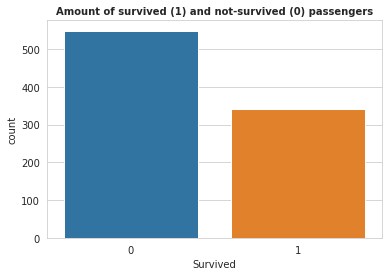

In [8]:
sns.countplot(x='Survived', data=titanic)
plt.title('Amount of survived (1) and not-survived (0) passengers', fontsize=10, fontweight='bold');

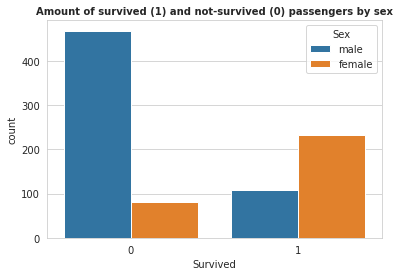

In [9]:
sns.countplot(x='Survived', data=titanic, hue='Sex')
plt.title('Amount of survived (1) and not-survived (0) passengers by sex', fontsize=10, fontweight='bold');

In [10]:
pd.crosstab(titanic['Sex'], titanic['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


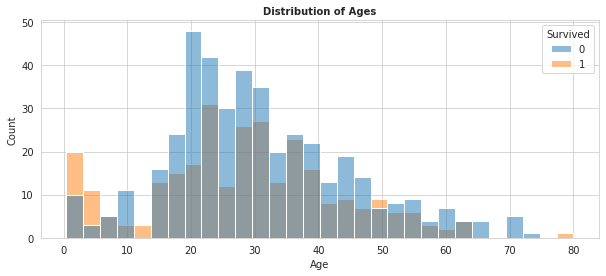

In [11]:
plt.figure(figsize=(10, 4))
sns.histplot(x='Age', data=titanic, hue='Survived', bins=30)
plt.title('Distribution of Ages', fontsize=10, fontweight='bold');

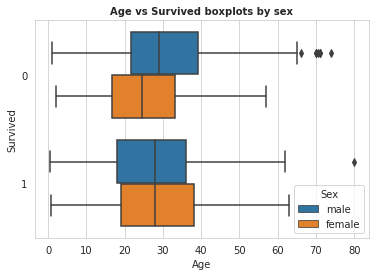

In [12]:
sns.boxplot(x='Age', y='Survived', data=titanic, orient='h', hue='Sex')
plt.title('Age vs Survived boxplots by sex', fontsize=10, fontweight='bold');

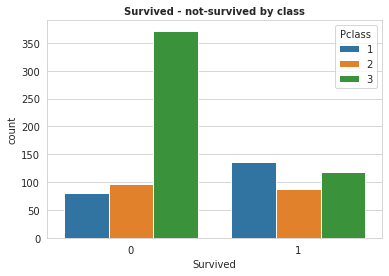

In [13]:
sns.countplot(x='Survived', data=titanic, hue='Pclass')
plt.title('Survived - not-survived by class', fontsize=10, fontweight='bold');

In [14]:
pd.crosstab(titanic['Sex'], titanic['Pclass'])

Pclass,1,2,3
Sex,,,
female,94,76,144
male,122,108,347


## Feature engineering

In [15]:
class TransformDF(BaseEstimator, TransformerMixin):
    """
    Applies transformation on initial database. Class has no parameters.
    This class allows to fill missing values in Age and Embarked features.
    
    Age filles by mean age of certain age group. For this purpose mean ages are
    calculated using Mr/Ms/Miss words from passengers names. If there are no such 
    words in passenger name, mean age of all passengers is used.
    Embarked feature is filled by most frequent value.
    
    Methods
        Methods of this class are similar to methods of usual sklearn transformer.
        
        fit:
            Fits initial database
            
        transform:
            Transform initial database
        
        fit_transform:
            Combination of fit and transform
            
    Return
        Formatted dataset with Age, Pclass, SibSp, Parch and Embarked columns.
    """
    def __init__(self):
        pass
    
    def __convert_string_to_list(self, string):
        """
        Hidden method. Converts string name literal to the list of words.
        """
        return string.lower().replace('.', '').replace(',', '').split(' ')
    
    def __fillna_age_in_name(self, df):
        """
        Hidden method. Fills NaN values by mean age of certain age groups.
        """
        df['Name_list'] = df['Name'].apply(self.__convert_string_to_list)
        mean_age_mr = df[df['Name_list'].apply(lambda row: 'mr' in row)]['Age'].mean()
        mean_age_mrs = df[df['Name_list'].apply(lambda row: 'mrs' in row)]['Age'].mean()
        mean_age_miss = df[df['Name_list'].apply(lambda row: 'miss' in row)]['Age'].mean()
        mean_age = df['Age'].mean()
        
        for ind in df[df['Age'].isna()].index:
            person = df.iloc[ind, :]
            if 'mr' in person['Name_list']:
                df.loc[ind, 'Age'] = mean_age_mr
            elif 'mrs' in person['Name_list']:
                df.loc[ind, 'Age'] = mean_age_mrs
            elif 'miss' in person['Name_list']:
                df.loc[ind, 'Age'] = mean_age_miss
            else:
                df.loc[ind, 'Age'] = mean_age
                
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        df.drop(['PassengerId', 'Cabin'], axis=1, inplace=True)
        self.__fillna_age_in_name(df)
        df['Embarked'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df['Embarked'].values.reshape(-1, 1))
#         df['Fare'] = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(df['Fare'].values.reshape(-1, 1))
        return df.drop(['Ticket', 'Name_list', 'Name', 'Fare'], axis=1)

class AddPCA(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X)
        return np.c_[X, X_pca]

In [16]:
column_transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(), [2, 3, 4]),  # 5 - Fare
                                                     ('encoder', OneHotEncoder(), [0, 1, -1])],
                                       remainder='passthrough')

In [17]:
pipeline = Pipeline([('transf1', TransformDF()),
                     ('col_tr', column_transformer)])

In [18]:
pipeline.fit(X)
X_tr = pipeline.transform(X)

In [131]:
X_test = pd.read_csv('./test.csv')
X_test_tr = pipeline.transform(X_test)

## Modelling

### Out-of-box algorithms assessment

In [91]:
logit = LogisticRegression(random_state=42)
cross_val_score(logit, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()

0.7890011223344556

In [92]:
sgd = SGDClassifier(random_state=42)
cross_val_score(sgd, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()

0.7508417508417509

In [93]:
svc = SVC(random_state=42, probability=True)
cross_val_scorea(svc, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()

0.8294051627384961

In [94]:
tree = DecisionTreeClassifier(random_state=42)
cross_val_score(tree, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()

0.7755331088664423

In [95]:
forest = RandomForestClassifier(random_state=42)
cross_val_score(forest, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()

0.7856341189674523

In [136]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()

0.8002244668911335

In [160]:
grbc = GradientBoostingClassifier()
cross_val_score(grbc, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()

0.8148148148148149

In [225]:
extra_tree = ExtraTreesClassifier()
cross_val_score(extra_tree, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()

0.7620650953984286

In [167]:
for alg in (logit, sgd, svc, tree, forest, knn, grbc):
    bc = BaggingClassifier(base_estimator=alg)
    score = cross_val_score(bc, X_tr, y, cv=3, scoring='accuracy', n_jobs=-1).mean()
    print(f'{alg.__class__.__name__}: {score}')

LogisticRegression: 0.7934904601571268
SGDClassifier: 0.7991021324354658
SVC: 0.8271604938271605
DecisionTreeClassifier: 0.7856341189674523
RandomForestClassifier: 0.7957351290684623
KNeighborsClassifier: 0.7923681257014591
GradientBoostingClassifier: 0.8226711560044894


## Model Tuning

### SVC

In [113]:
%%time

svc = SVC(probability=True, random_state=42)

param_grid = {'C': [0.5, 1, 1.5],
              'kernel': ['rbf'],
              'degree': [3],
              'gamma': [0.05, 0.1, 0.15],
              'shrinking': [True]}
grid_svc = GridSearchCV(svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_tr, y)

CPU times: user 335 ms, sys: 4.06 ms, total: 339 ms
Wall time: 1.49 s


GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.5, 1, 1.5], 'degree': [3],
                         'gamma': [0.05, 0.1, 0.15], 'kernel': ['rbf'],
                         'shrinking': [True]},
             scoring='accuracy')

In [114]:
grid_svc.best_score_

0.8305274971941637

In [115]:
grid_svc.best_params_

{'C': 1.5, 'degree': 3, 'gamma': 0.15, 'kernel': 'rbf', 'shrinking': True}

In [116]:
svc_tuned = grid_svc.best_estimator_

In [119]:
with open('./models/svc_model.pkl', 'wb') as f:
    pickle.dump(svc_tuned, file=f)
    f.close()

### Logistic Regression

In [105]:
logit = LogisticRegression()
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty': ['l1', 'l2']}

grid_logit = GridSearchCV(logit, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_logit.fit(X_tr, y)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [106]:
grid_logit.best_score_

0.7957351290684623

In [107]:
grid_logit.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

In [108]:
logit_tuned = grid_logit.best_estimator_

In [122]:
with open('./models/logit_model.pkl', 'wb') as f:
    pickle.dump(logit_tuned, file=f)
    f.close()

### RandomForestClassifier

In [109]:
%%time
forest = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators': [100, 150, 200, 250],
              'max_depth': [1, 3, 5, 7, 9],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3],
              'max_features': [3, 4, 8, 14], 
              'bootstrap': [True, False]}

grid_forest = GridSearchCV(forest, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_forest.fit(X_tr, y)

CPU times: user 14.8 s, sys: 1.25 s, total: 16 s
Wall time: 11min 48s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_features': [3, 4, 8, 14],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='accuracy')

In [110]:
grid_forest.best_score_

0.8226711560044894

In [111]:
grid_forest.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [112]:
forest_tuned = grid_forest.best_estimator_

In [124]:
with open('./models/forest_model.pkl', 'wb') as f:
    pickle.dump(forest_tuned, file=f)
    f.close()

### KNN

In [140]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [11, 13, 15],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}
grid_knn = GridSearchCV(knn, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_knn.fit(X_tr, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [11, 13, 15],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [141]:
grid_knn.best_score_

0.8103254769921436

In [142]:
grid_knn.best_params_

{'algorithm': 'brute', 'n_neighbors': 11, 'weights': 'uniform'}

In [143]:
knn_tuned = grid_knn.best_estimator_

In [144]:
with open('./models/knn_model.pkl', 'wb') as f:
    pickle.dump(obj=knn_tuned, file=f)
    f.close()

### BaggingClassifier

In [215]:
bc = BaggingClassifier(base_estimator=svc_tuned, bootstrap=False, random_state=42)
param_grid = {'n_estimators': [30],
              'max_samples': [0.9, 0.8],
              'max_features': [1.0]}
grid_bagging = GridSearchCV(bc, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_bagging.fit(X_tr, y)

GridSearchCV(cv=3,
             estimator=BaggingClassifier(base_estimator=SVC(C=1.5, gamma=0.15,
                                                            probability=True,
                                                            random_state=42),
                                         bootstrap=False, random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [1.0], 'max_samples': [0.9, 0.8],
                         'n_estimators': [30]},
             scoring='accuracy')

In [216]:
grid_bagging.best_score_

0.8316498316498318

In [217]:
grid_bagging.best_params_

{'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 30}

In [218]:
bagging_tuned = grid_bagging.best_estimator_

In [219]:
with open('./models/bagging_svc_model.pkl', 'wb') as f:
    pickle.dump(obj=knn_tuned, file=f)
    f.close()

### Test voting classifier

In [151]:
ensemble = VotingClassifier(estimators=[('svc', svc_tuned),
                                        ('lgr', logit_tuned),
                                        ('frst', forest_tuned),
                                        ('knn', knn_tuned)],
                            voting='hard')
cross_val_score(ensemble, X_tr, y, cv=3, scoring='accuracy', verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


0.830527497194164

In [152]:
ensemble.fit(X_tr, y)

VotingClassifier(estimators=[('svc',
                              SVC(C=1.5, gamma=0.15, probability=True,
                                  random_state=42)),
                             ('lgr',
                              LogisticRegression(C=0.01, solver='liblinear')),
                             ('frst',
                              RandomForestClassifier(max_depth=5,
                                                     max_features=4,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('knn',
                              KNeighborsClassifier(algorithm='brute',
                                                   n_neighbors=11))])

In [155]:
pred_test = ensemble.predict(X_test_tr)

In [158]:
save_solution(X_test, pred_test, sol_num=10)